In [1]:
# As usual, a bit of setup
import sys
sys.path.append('../')
import time, os, json

# ensures back compatibility
from tensorflow.keras import backend as K

# for reading and preprocessing data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# inceptionv4 model from keras with pretrained weights
from tensorflow.python.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
import tensorflow as tf
# inception_resnet_v2.InceptionResNetV2

# for plots et al.
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

# from ie590.classifiers.squeezenet import SqueezeNet
# from ie590.data_utils import load_tiny_imagenet
# from ie590.image_utils import preprocess_image, deprocess_image
# from ie590.image_utils import SQUEEZENET_MEAN, SQUEEZENET_STD

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
DATASET_PATH  = './weed_data'
IMAGE_SIZE    = (300, 300)
NUM_CLASSES   = 4
BATCH_SIZE    = 8
NUM_EPOCHS    = 20
WEIGHTS_FINAL = 'model-inception_resnet_v2-final.h5'

In [3]:
# inceptionv4 - model setup
model = InceptionResNetV2(include_top=False,
                        weights='imagenet',
                        input_tensor=None,
                        input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
# adding final FC layer at the end of model
x = model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
output_layer = Dense( NUM_CLASSES,
                      activation='softmax',
                      name='softmax')(x)

model = Model(inputs=model.input,
              outputs=output_layer)

In [4]:
# loading weights
status = model.load_weights(WEIGHTS_FINAL)
model.trainable = False

In [5]:
######################################################################################
# from : https://fairyonice.github.io/Saliency-Map-with-keras-vis.html
######################################################################################
import json
CLASS_INDEX = json.load(open('classes.json'))
classlabel = []
for i_dict in CLASS_INDEX['weed']:
    classlabel.append(i_dict['class'])
print("N of class={}".format(len(classlabel)))

N of class=4


In [6]:
import PIL

def load_image(file_path):
    im = PIL.Image.open(file_path)
    im = im.resize((300,300))
    im = np.asarray(im)
#     return im
    return im / 127.5 - 1.0

In [15]:
def get_output_layer(model, layer_name):
    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    layer = layer_dict[layer_name]
    return layer

def visualize_class_activation_map(model_path, img_path, output_path):
    model = model_path
    original_img = load_image(img_path)
    width, height, _ = original_img.shape

    #Reshape to the network input shape (3, w, h).
    img = np.array([np.transpose(np.float32(original_img), (2, 0, 1))])

    #Get the 512 input weights to the softmax.
    class_weights = model.layers[-1].get_weights()[0]
    final_conv_layer = get_output_layer(model, 'softmax')
    get_output = K.function([model.layers[0].input], \
                [final_conv_layer.output, 
    model.layers[-1].output])
    [conv_outputs, predictions] = get_output([img])
    conv_outputs = conv_outputs[0, :, :, :]

    #Create the class activation map.
    cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[1:3])
    target_class = 1
    for i, w in enumerate(class_weights[:, target_class]):
            cam += w * conv_outputs[i, :, :]

In [16]:
# import cv2

img_path = './weed_data/train/cocklebur/7.png'
output_path = './output/'

visualize_class_activation_map(model, img_path, output_path)

NotFoundError:  No algorithm worked!
	 [[node conv2d/Conv2D (defined at /home/salazar/anaconda3/envs/capsnet/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1751) ]] [Op:__inference_keras_scratch_graph_29421]

Function call stack:
keras_scratch_graph


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


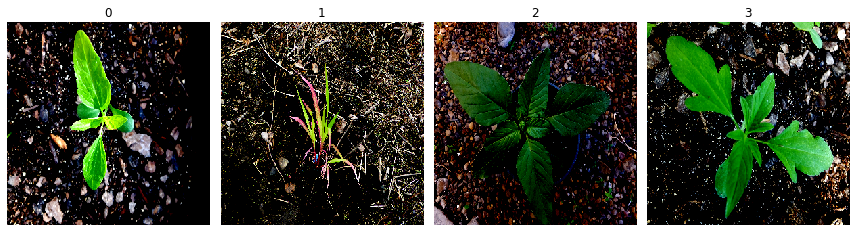

In [62]:
######################################################################################
# from : HW3
######################################################################################

# visualize image
file_path1 = './weed_data/train/cocklebur/7.png'
file_path2 = './weed_data/train/foxtail/P1020337.JPG'
file_path3 = './weed_data/train/pigweed/DSCF3791.png'
file_path4 = './weed_data/train/ragweed/DSCF3856.png'

X_raw = np.zeros([4,300,300,3])
X_raw[0] = load_image(file_path1)
X_raw[1] = load_image(file_path2)
X_raw[2] = load_image(file_path3)
X_raw[3] = load_image(file_path4)
y = [0,1,2,3]

plt.figure(figsize=(12, 6))
for i in range(0,4):
    plt.subplot(1,4,i+1)
    plt.imshow(X_raw[i])
    plt.title(y[i])
    plt.axis('off')
plt.gcf().tight_layout()


In [63]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images, numpy array of shape (N, H, W, 3)
    - y: Labels for X, numpy of shape (N,)
    - model: A SqueezeNet model that will be used to compute the saliency map.

    Returns:
    - saliency: A numpy array of shape (N, H, W) giving the saliency maps for the
    input images.
    """ 
    N = X.shape[0]
    X = tf.convert_to_tensor(X)
    
    with tf.GradientTape() as t:
        t.watch(X)        
        correct_scores = tf.gather_nd(model(X),
                            tf.stack((tf.range(N), y), axis=1))
        grad = t.gradient(correct_scores,X)
    
    saliency = tf.math.reduce_max(tf.abs(grad), axis=3)
    
    return saliency

In [64]:
SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
SQUEEZENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def preprocess_image(img):
    return (img.astype(np.float32)/255.0 - SQUEEZENET_MEAN) / SQUEEZENET_STD
X = np.array([preprocess_image(img) for img in X_raw])

In [68]:
def show_saliency_maps(X, y, mask):
    mask = np.asarray(mask)
    print(mask)
    Xm = X[mask]
#     ym = y[mask]
    ym = 0

    saliency = compute_saliency_maps(Xm, ym, model)

    for i in range(mask.size):
        plt.subplot(2, mask.size, i + 1)
        plt.imshow(deprocess_image(Xm[i]))
        plt.axis('off')
        plt.title(class_names[ym[i]])
        plt.subplot(2, mask.size, mask.size + i + 1)
        plt.title(mask[i])
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(10, 4)
    plt.show()

mask = np.arange(0,4)
print(mask)
show_saliency_maps(X, y, mask)

[0 1 2 3]
[0 1 2 3]


InvalidArgumentError: Shapes of all inputs must match: values[0].shape = [4] != values[1].shape = [] [Op:Pack] name: stack